In [69]:
import torch
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
import glob
from PIL import Image


In [70]:
learning_rate = 0.001
batch_size = 10
epochs = 10

device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1234)
if device == 'cuda':
    torch.cuda.manual_seed_all(1234)


print(device)

cpu


In [71]:
def create_dataset():
    df1 = pd.read_csv("rose.csv", sep=',',
                      header=None, encoding='UTF-16')
                      
    df2 = pd.read_csv("tulip.csv", sep=',',
                      header=None, encoding='UTF-16')
    df = pd.concat([df1, df2], ignore_index=True)
    df.drop(1, axis=1, inplace=True)
    df.rename(columns={0: 'AbsolutePath', 2: 'DatasetClass'}, inplace=True)
    return df

df = create_dataset() 
print(df)

                           AbsolutePath DatasetClass
0      D:\rtfiles\dataset\rose\0001.jpg         rose
1      D:\rtfiles\dataset\rose\0002.jpg         rose
2      D:\rtfiles\dataset\rose\0003.jpg         rose
3      D:\rtfiles\dataset\rose\0004.jpg         rose
4      D:\rtfiles\dataset\rose\0005.jpg         rose
...                                 ...          ...
2035  D:\rtfiles\dataset\tulip\1016.jpg        tulip
2036  D:\rtfiles\dataset\tulip\1017.jpg        tulip
2037  D:\rtfiles\dataset\tulip\1018.jpg        tulip
2038  D:\rtfiles\dataset\tulip\1019.jpg        tulip
2039  D:\rtfiles\dataset\tulip\1020.jpg        tulip

[2040 rows x 2 columns]


In [72]:

path_test= os.path.join("D:\\", "pylab5", "test_set")
path_train = os.path.join("D:\\", "pylab5", "train_set")
path_val = os.path.join("D:\\", "pylab5", "validation_set")

def load_set(df: pd.DataFrame, path: str, number: int):
        image_path = df["AbsolutePath"][number]
        image = cv2.imread(image_path)
        new_path = os.path.join(path, f'{df.DatasetClass[number]}.{number}.jpg')
        cv2.imwrite(new_path, image)


def load_test_set(df: pd.DataFrame, path: str, number: int):
    image_path = df["AbsolutePath"][number]
    image = cv2.imread(image_path)
    if number - 816 > 102:
        number = number - 1734
    else:
        number = number - 816
    cv2.imwrite(os.path.join(path, f'{number}.jpg'), image)


for i in range(816):
    load_set(df, path_train, i)
for i in range(816, 918):
    load_test_set(df, path_test, i)
for i in range(918, 1020):
    load_set(df, path_val, i)
for i in range(1020, 1836):
    load_set(df, path_train, i)
for i in range(1836, 1938):
    load_test_set(df, path_test, i)
for i in range(1938, 2040):
    load_set(df, path_val, i)


In [73]:
train_list = glob.glob(os.path.join(path_train, '*.jpg'))
test_list = glob.glob(os.path.join(path_test, '*.jpg'))

train_list, val_list = train_test_split(train_list, test_size=0.1)

[380 275 620 473 793 465 656 192 146 554]


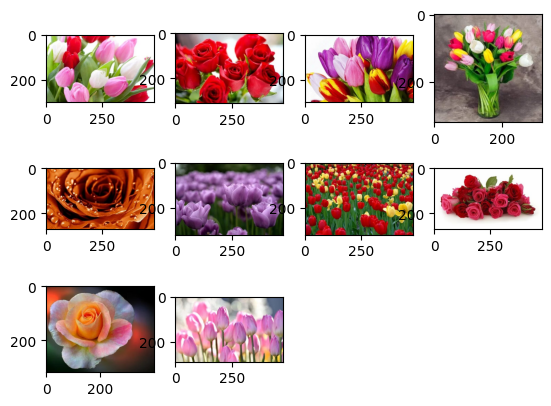

In [74]:
index = np.random.randint(1, 800, size=10)
print(index)
fig = plt.figure()
i = 1
for idx in index:
    ax = fig.add_subplot(3, 4, i)
    img = cv2.imread(train_list[idx])
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    i += 1
plt.show()

In [75]:
class CNN(nn.Module):
    def __init__(self) -> None:
        super(CNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
            
        self.fc1 = nn.Linear(576, 10)   #7*7*64
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10, 2)
        self.relu = nn.ReLU()
        
    def forward(self, x: torch.tensor) -> torch.tensor:
        output = self.layer1(x)
        output = self.layer2(output)
        output = self.layer3(output)
        output = output.view(output.size(0),-1)
        output = self.relu(self.fc1(output))
        output = self.fc2(output)   
        return torch.nn.Sigmoid()(output)

model = CNN().to(device)
model.train()
optimizer = optim.Adam(params = model.parameters(),lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [76]:
train_transforms =  transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

test_transforms = transforms.Compose([   
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    ])

In [77]:
class dataset(torch.utils.data.Dataset):
    def __init__(self, file_list, transform=None) -> None:
        '''dataset class constructur'''
        self.file_list = file_list
        self.transform = transform

    def __len__(self) -> int:
        '''get len'''
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx) -> type:
        '''function return item of dataset'''
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        label = img_path.split('\\')[-1].split('.')[0]
        if label == 'rose':
            label = 1
        elif label == 'tulip':
            label = 0

        return img_transformed, label


train_data = dataset(train_list, transform=train_transforms)
test_data = dataset(test_list, transform=test_transforms)
val_data = dataset(val_list, transform=val_transforms)

train_loader = torch.utils.data.DataLoader(
    dataset=train_data, batch_size=10, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    dataset=test_data, batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(
    dataset=val_data, batch_size=10, shuffle=True)

Learning rate: 0.001, Batch size: 10
Epoch : 1, train accuracy : 0.706803023815155, train loss : 0.6112316846847534
Epoch : 1, val_accuracy : 0.7323528528213501, val_loss : 0.565330982208252
Epoch : 2, train accuracy : 0.7576533555984497, train loss : 0.5516095757484436
Epoch : 2, val_accuracy : 0.8176470398902893, val_loss : 0.4967648983001709
Epoch : 3, train accuracy : 0.767857551574707, train loss : 0.5295343995094299
Epoch : 3, val_accuracy : 0.7558823227882385, val_loss : 0.5335542559623718
Epoch : 4, train accuracy : 0.79557865858078, train loss : 0.5088977813720703
Epoch : 4, val_accuracy : 0.8588234782218933, val_loss : 0.4674774706363678
Epoch : 5, train accuracy : 0.8241501450538635, train loss : 0.4812995493412018
Epoch : 5, val_accuracy : 0.8647058606147766, val_loss : 0.44584032893180847
Epoch : 6, train accuracy : 0.799660325050354, train loss : 0.5013789534568787
Epoch : 6, val_accuracy : 0.8029411435127258, val_loss : 0.5007076263427734
Epoch : 7, train accuracy : 0.81

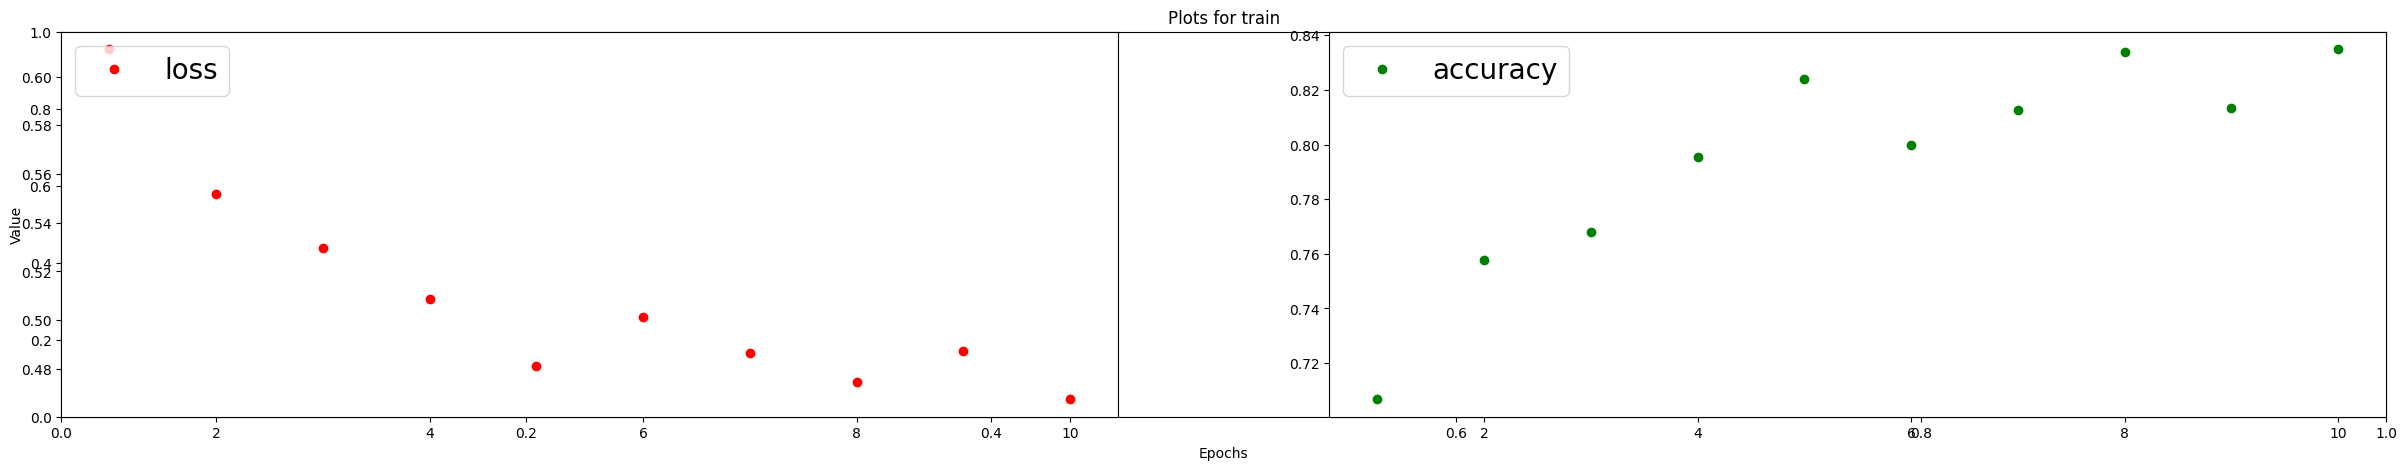

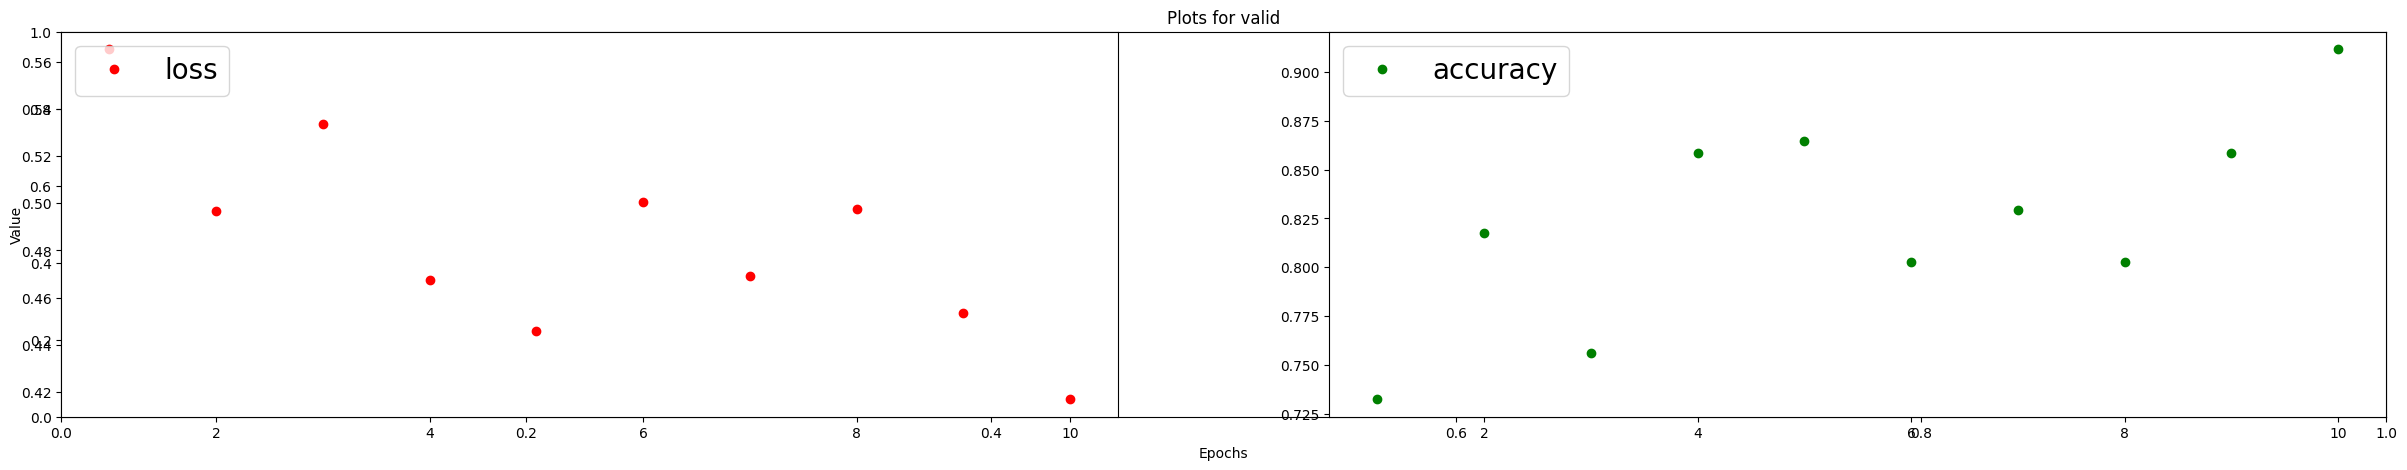

In [78]:
print('Learning rate: 0.001, Batch size: 10')

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_loader = torch.utils.data.DataLoader(
    dataset=train_data, batch_size=10, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    dataset=test_data, batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(
    dataset=val_data, batch_size=10, shuffle=True)

epochs = 10


def train_loop(train_loader: torch.utils.data.DataLoader, val_loader: torch.utils.data.DataLoader, epochs: int):
    '''train loop for train and validate cnn'''
    val_loss_list = []
    val_accuracy_list = []

    loss_list = []
    accuracy_list = []

    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0

        for data, label in train_loader:
            data = data.to(device)
            label = label.to(device)

            output = model(data)
            loss = criterion(output, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            acc = ((output.argmax(dim=1) == label).float().mean())
            epoch_accuracy += acc/len(train_loader)
            epoch_loss += loss/len(train_loader)

        loss_list.append(epoch_loss.item())
        accuracy_list.append(epoch_accuracy.item())

        print('Epoch : {}, train accuracy : {}, train loss : {}'.format(
            epoch+1, epoch_accuracy, epoch_loss))

        with torch.no_grad():
            epoch_val_accuracy = 0
            epoch_val_loss = 0

            for data, label in val_loader:
                data = data.to(device)
                label = label.to(device)

                val_output = model(data)
                val_loss = criterion(val_output, label)

                acc = ((val_output.argmax(dim=1) == label).float().mean())
                epoch_val_accuracy += acc / len(val_loader)
                epoch_val_loss += val_loss / len(val_loader)

            val_loss_list.append(epoch_val_loss.item())
            val_accuracy_list.append(epoch_val_accuracy.item())

            print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(
                epoch+1, epoch_val_accuracy, epoch_val_loss))

    num_epochs = [i+1 for i in range(epochs)]

    fig = plt.figure(figsize=(30, 5))
    plt.title('Plots for train')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    fig.add_subplot(1, 2, 1)
    plt.plot(num_epochs, loss_list, 'ro', label='loss')
    plt.legend(loc=2, prop={'size': 20})
    fig.add_subplot(1, 2, 2)
    plt.plot(num_epochs, accuracy_list, 'go', label='accuracy')
    plt.legend(loc=2, prop={'size': 20})

    fig = plt.figure(figsize=(30, 5))
    plt.title('Plots for valid')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    fig.add_subplot(1, 2, 1)
    plt.plot(num_epochs, val_loss_list, 'ro', label='loss')
    plt.legend(loc=2, prop={'size': 20})
    fig.add_subplot(1, 2, 2)
    plt.plot(num_epochs, val_accuracy_list, 'go', label='accuracy')
    plt.legend(loc=2, prop={'size': 20})


train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0005, Batch size: 10
Epoch : 1, train accuracy : 0.847619891166687, train loss : 0.4552956819534302
Epoch : 1, val_accuracy : 0.8441177010536194, val_loss : 0.4680721163749695
Epoch : 2, train accuracy : 0.8476196527481079, train loss : 0.4570944309234619
Epoch : 2, val_accuracy : 0.8970588445663452, val_loss : 0.4227865934371948
Epoch : 3, train accuracy : 0.857653796672821, train loss : 0.4478130638599396
Epoch : 3, val_accuracy : 0.9000000357627869, val_loss : 0.4303136169910431
Epoch : 4, train accuracy : 0.8501706123352051, train loss : 0.4524420499801636
Epoch : 4, val_accuracy : 0.8882352709770203, val_loss : 0.4212836027145386
Epoch : 5, train accuracy : 0.8532323241233826, train loss : 0.45375874638557434
Epoch : 5, val_accuracy : 0.8382353186607361, val_loss : 0.4648045599460602
Epoch : 6, train accuracy : 0.861905574798584, train loss : 0.44570162892341614
Epoch : 6, val_accuracy : 0.8205881714820862, val_loss : 0.48327162861824036
Epoch : 7, train accuracy 

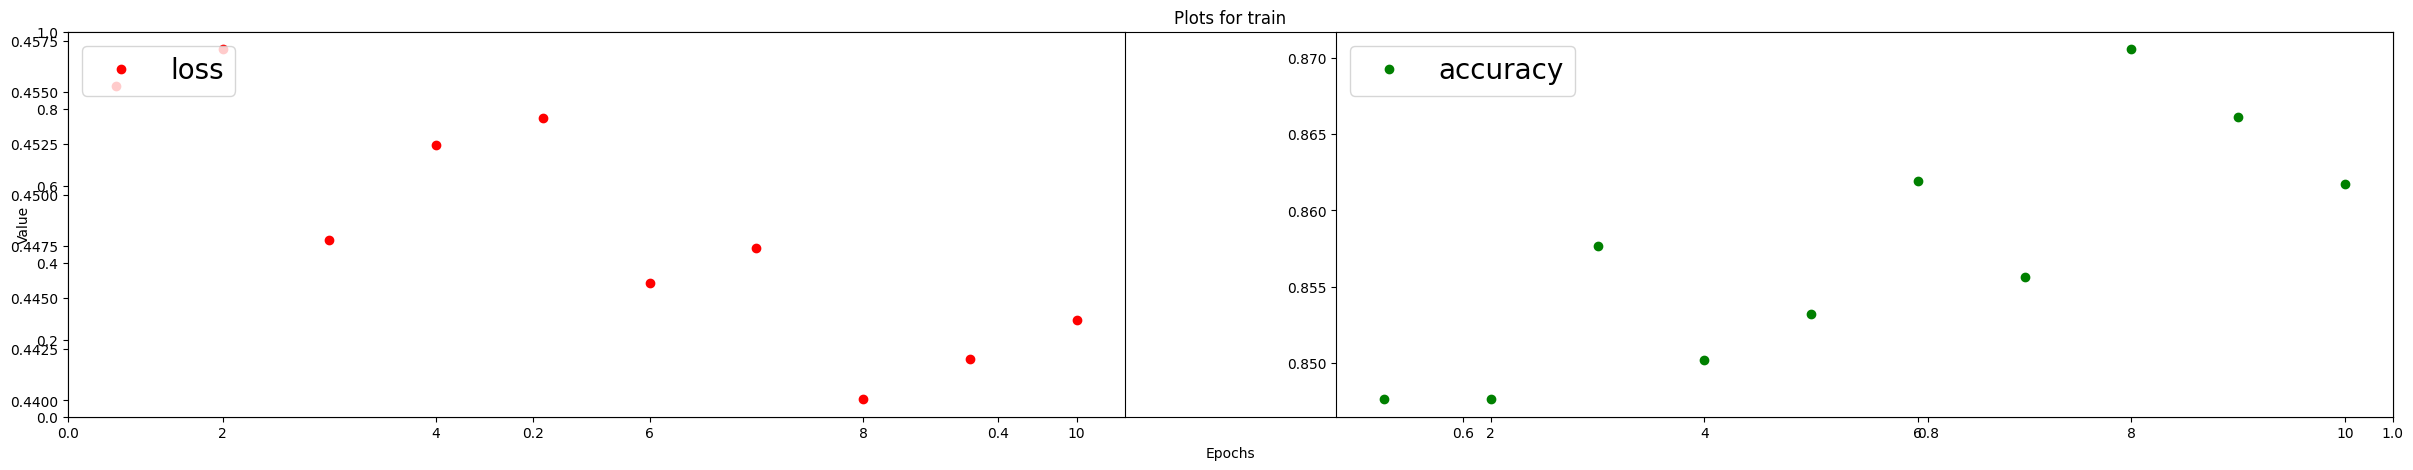

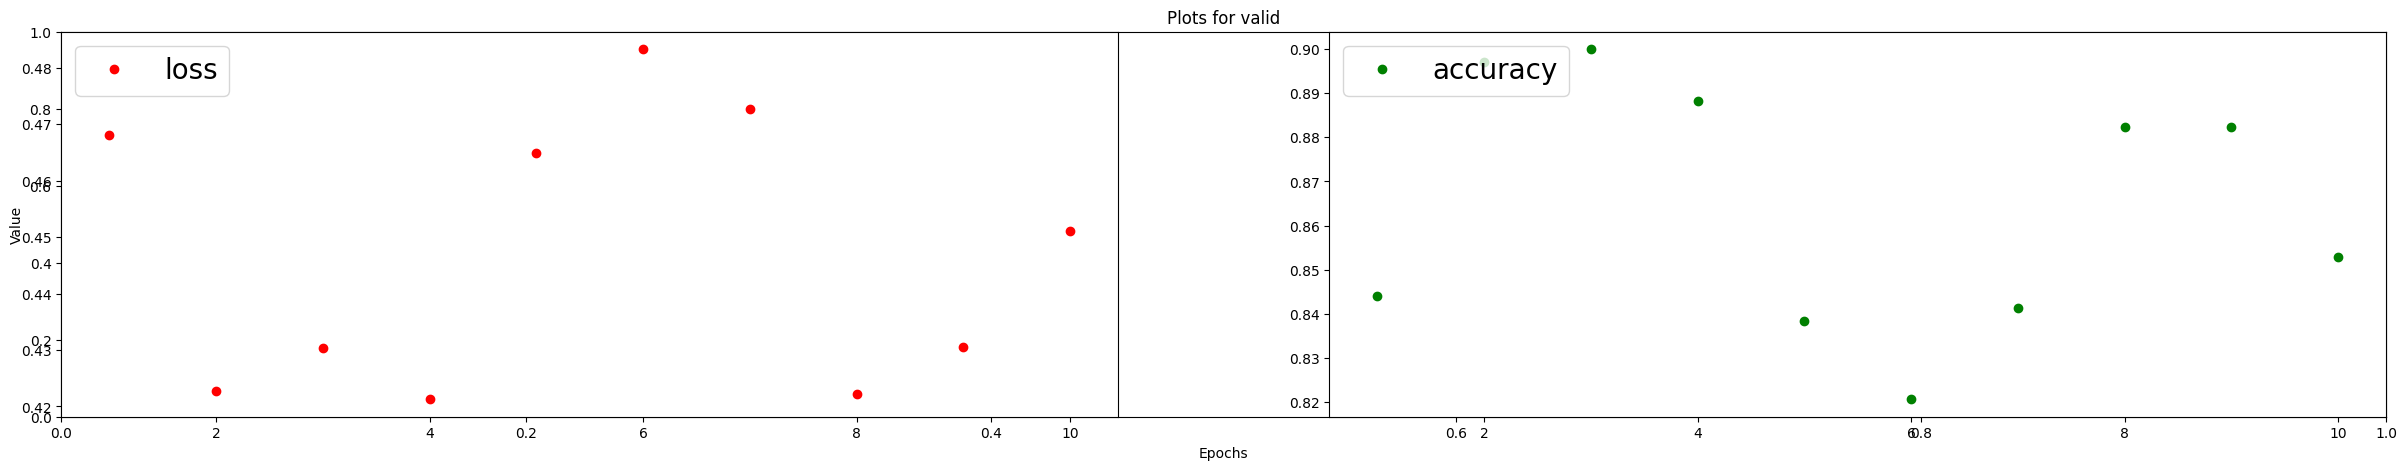

In [79]:
print('Learning rate: 0.0005, Batch size: 10')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

train_loader = torch.utils.data.DataLoader(
    dataset=train_data, batch_size=10, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    dataset=test_data, batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(
    dataset=val_data, batch_size=10, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0007, Batch size: 10
Epoch : 1, train accuracy : 0.8562933802604675, train loss : 0.4483957588672638
Epoch : 1, val_accuracy : 0.8764706254005432, val_loss : 0.42465081810951233
Epoch : 2, train accuracy : 0.8687081933021545, train loss : 0.4408048987388611
Epoch : 2, val_accuracy : 0.8647059798240662, val_loss : 0.43108370900154114
Epoch : 3, train accuracy : 0.8588441610336304, train loss : 0.4480466842651367
Epoch : 3, val_accuracy : 0.8823529481887817, val_loss : 0.421970009803772
Epoch : 4, train accuracy : 0.8690484762191772, train loss : 0.4399874806404114
Epoch : 4, val_accuracy : 0.8794117569923401, val_loss : 0.4287561774253845
Epoch : 5, train accuracy : 0.8663272857666016, train loss : 0.4407018721103668
Epoch : 5, val_accuracy : 0.8470587730407715, val_loss : 0.45508837699890137
Epoch : 6, train accuracy : 0.859524667263031, train loss : 0.4469664692878723
Epoch : 6, val_accuracy : 0.8058823943138123, val_loss : 0.4972984492778778
Epoch : 7, train accuracy

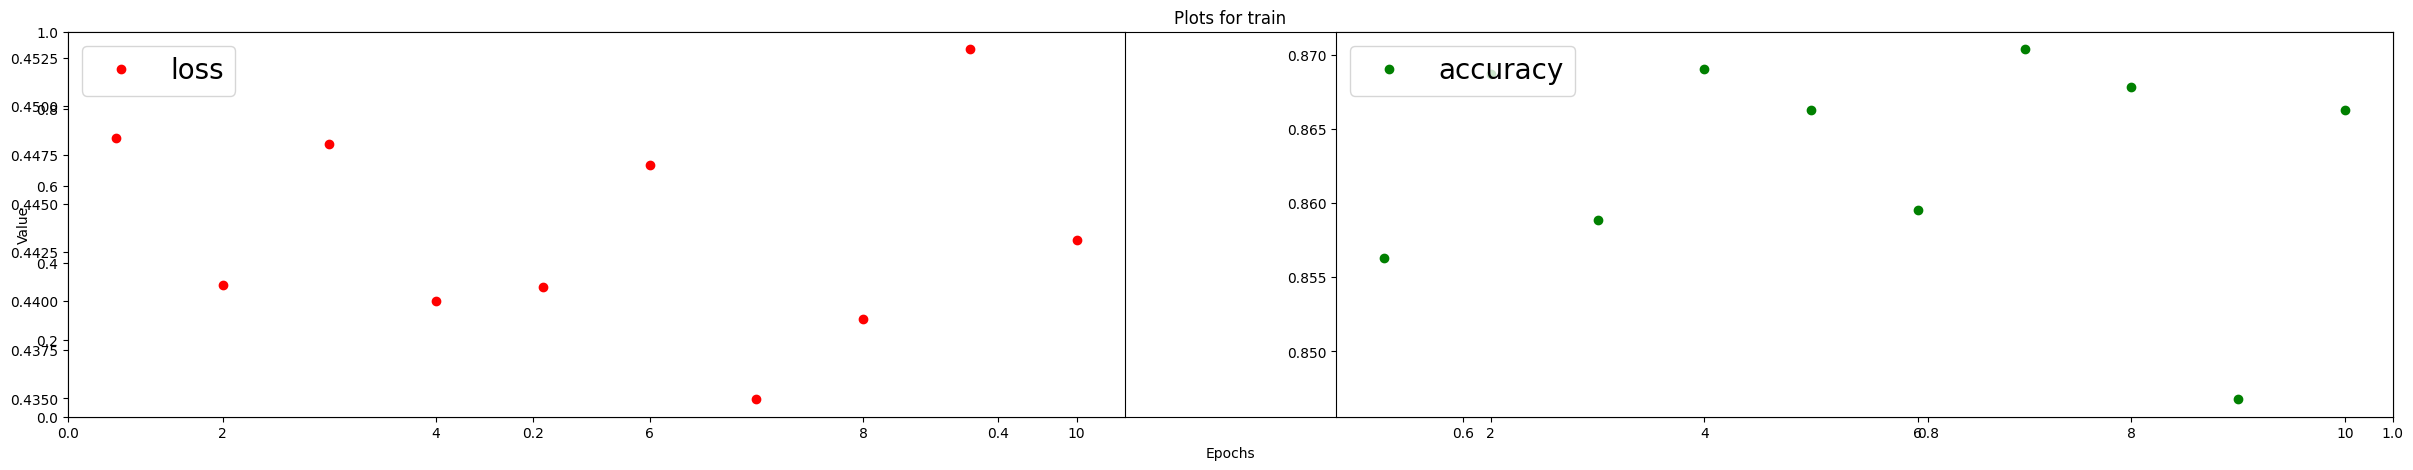

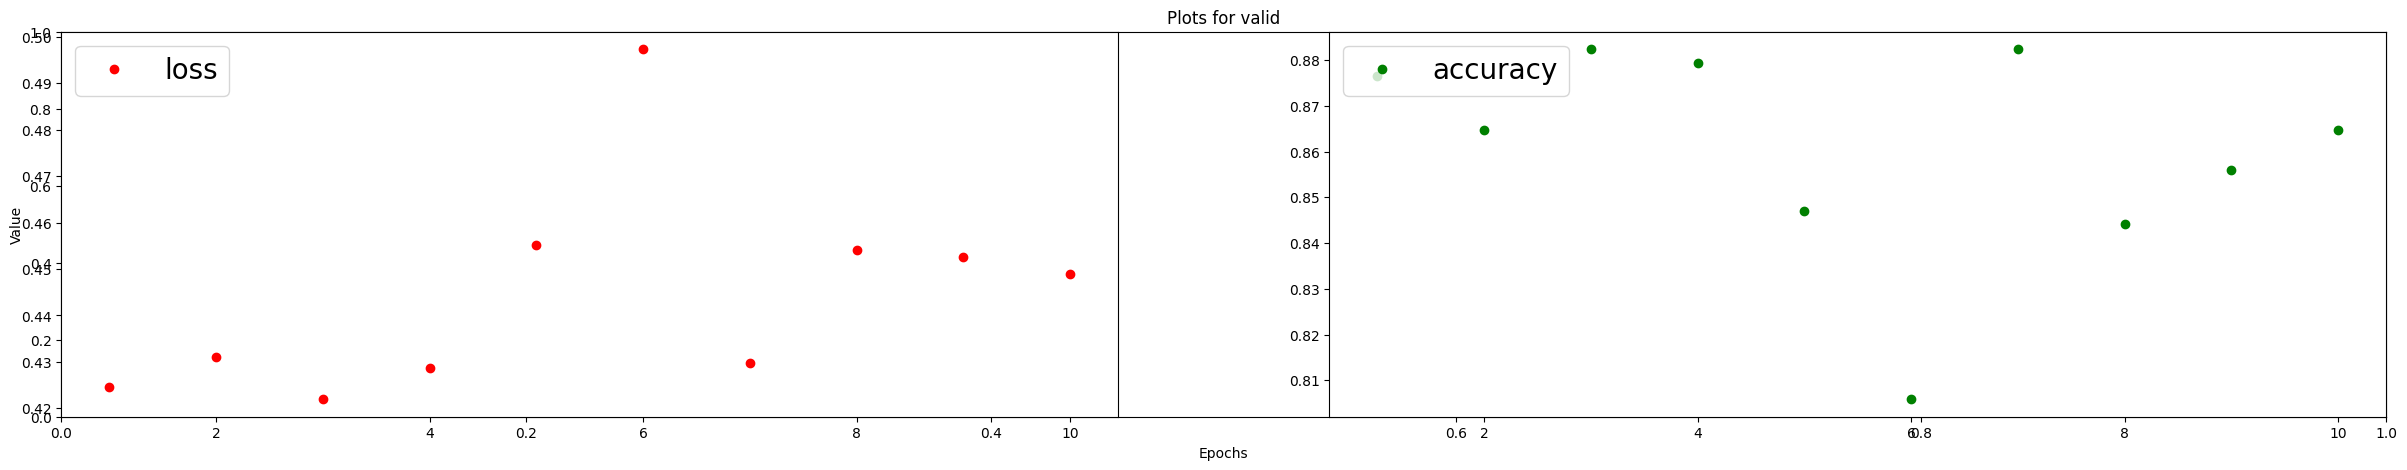

In [80]:
print('Learning rate: 0.0007, Batch size: 10')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

train_loader = torch.utils.data.DataLoader(
    dataset=train_data, batch_size=10, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    dataset=test_data, batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(
    dataset=val_data, batch_size=10, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.001, Batch size: 20
Epoch : 1, train accuracy : 0.8763508796691895, train loss : 0.4247159957885742
Epoch : 1, val_accuracy : 0.8777777552604675, val_loss : 0.4435567259788513
Epoch : 2, train accuracy : 0.8810806274414062, train loss : 0.4262635409832001
Epoch : 2, val_accuracy : 0.9333332777023315, val_loss : 0.3867766857147217
Epoch : 3, train accuracy : 0.8685805201530457, train loss : 0.43697425723075867
Epoch : 3, val_accuracy : 0.8722222447395325, val_loss : 0.43841010332107544
Epoch : 4, train accuracy : 0.8834455013275146, train loss : 0.42704010009765625
Epoch : 4, val_accuracy : 0.7833333015441895, val_loss : 0.5039922595024109
Epoch : 5, train accuracy : 0.883107602596283, train loss : 0.42516541481018066
Epoch : 5, val_accuracy : 0.9055555462837219, val_loss : 0.40018993616104126
Epoch : 6, train accuracy : 0.8854725360870361, train loss : 0.42304691672325134
Epoch : 6, val_accuracy : 0.8944444060325623, val_loss : 0.41835135221481323
Epoch : 7, train accu

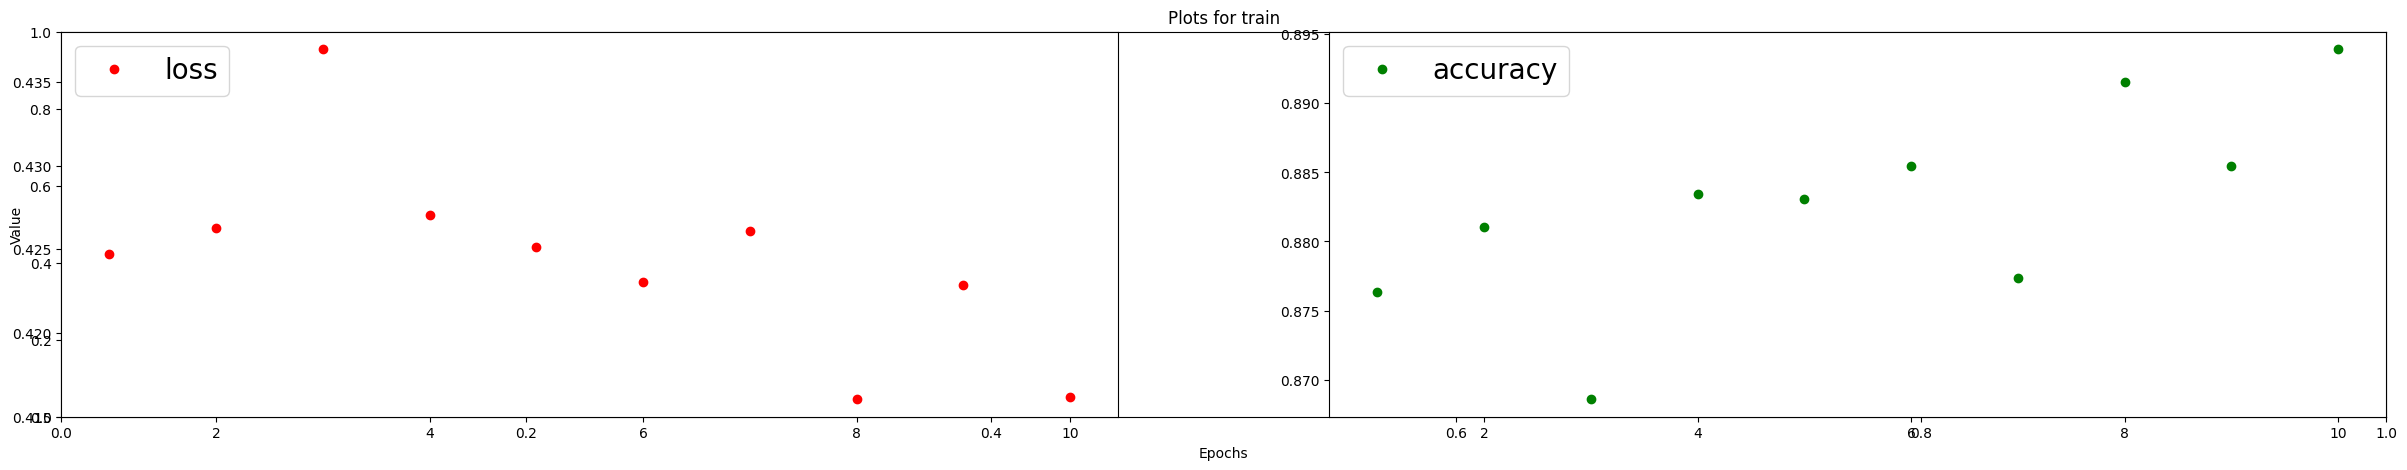

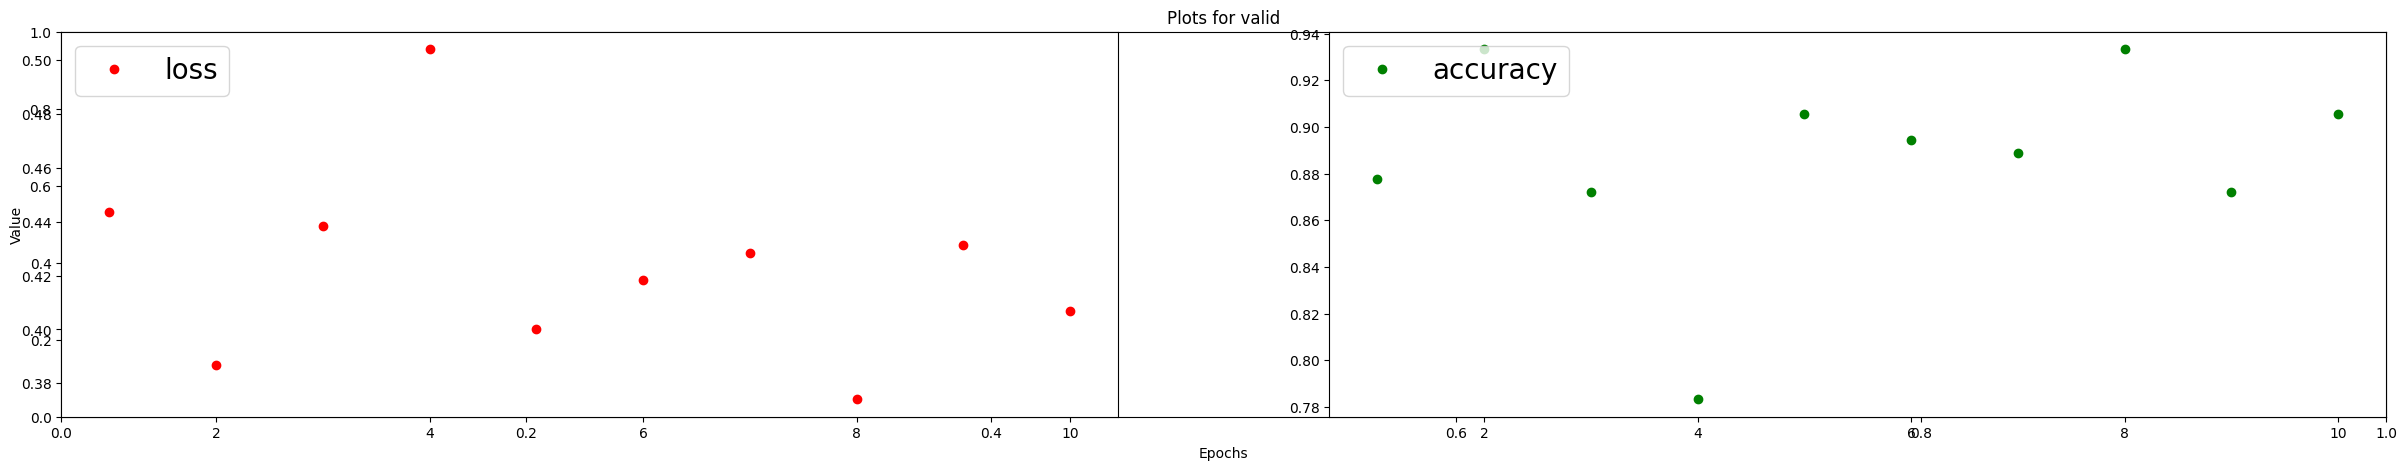

In [81]:
print('Learning rate: 0.001, Batch size: 20')

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loader = torch.utils.data.DataLoader(
    dataset=train_data, batch_size=20, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    dataset=test_data, batch_size=20, shuffle=True)
val_loader = torch.utils.data.DataLoader(
    dataset=val_data, batch_size=20, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0005, Batch size: 20
Epoch : 1, train accuracy : 0.8918915390968323, train loss : 0.41461822390556335
Epoch : 1, val_accuracy : 0.8777776956558228, val_loss : 0.42146730422973633
Epoch : 2, train accuracy : 0.8962833285331726, train loss : 0.41102132201194763
Epoch : 2, val_accuracy : 0.8777777552604675, val_loss : 0.4342837631702423
Epoch : 3, train accuracy : 0.8949319124221802, train loss : 0.4150647521018982
Epoch : 3, val_accuracy : 0.911111056804657, val_loss : 0.42194902896881104
Epoch : 4, train accuracy : 0.8949319124221802, train loss : 0.413774698972702
Epoch : 4, val_accuracy : 0.8388888835906982, val_loss : 0.461681067943573
Epoch : 5, train accuracy : 0.9054049253463745, train loss : 0.40371280908584595
Epoch : 5, val_accuracy : 0.9222223162651062, val_loss : 0.3921983242034912
Epoch : 6, train accuracy : 0.9006751775741577, train loss : 0.40959250926971436
Epoch : 6, val_accuracy : 0.9055555462837219, val_loss : 0.40259817242622375
Epoch : 7, train accur

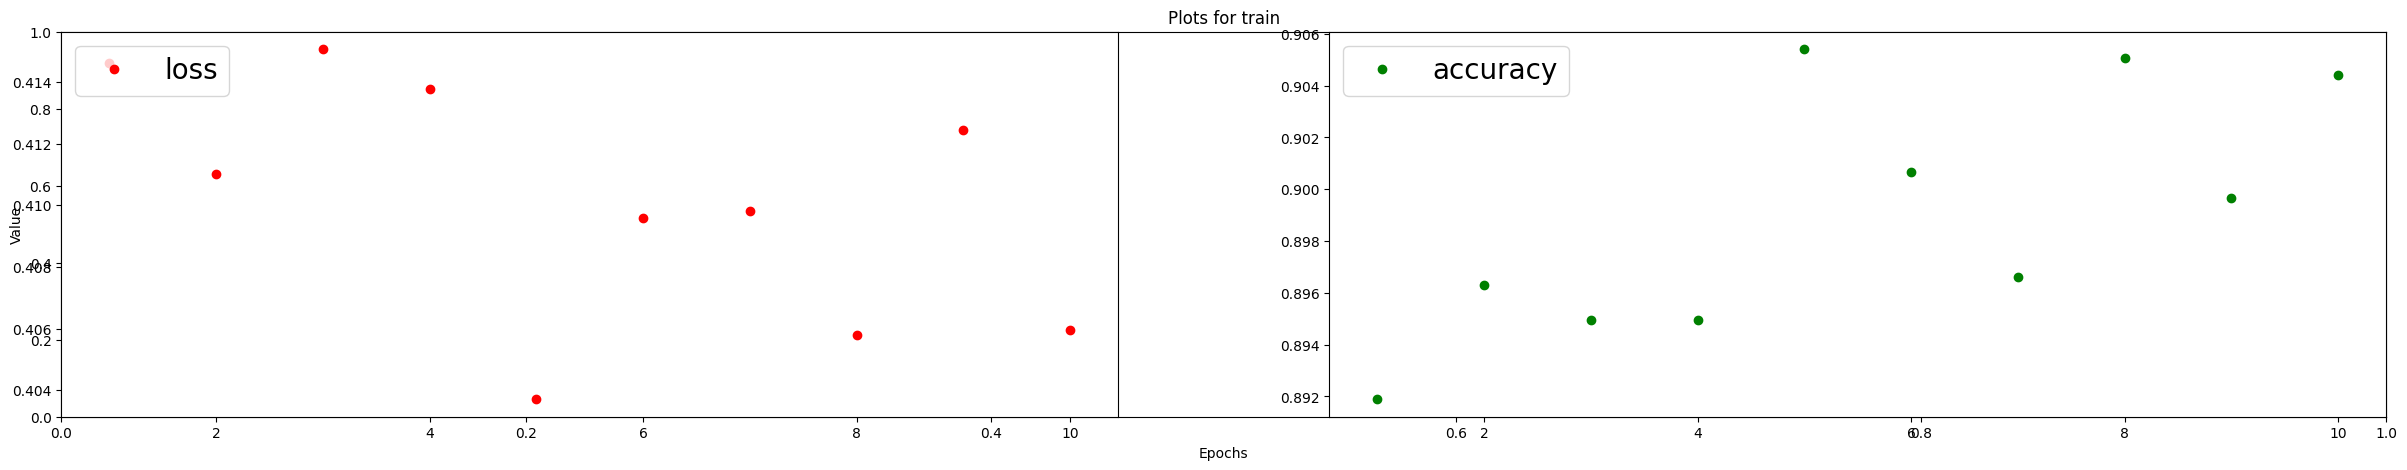

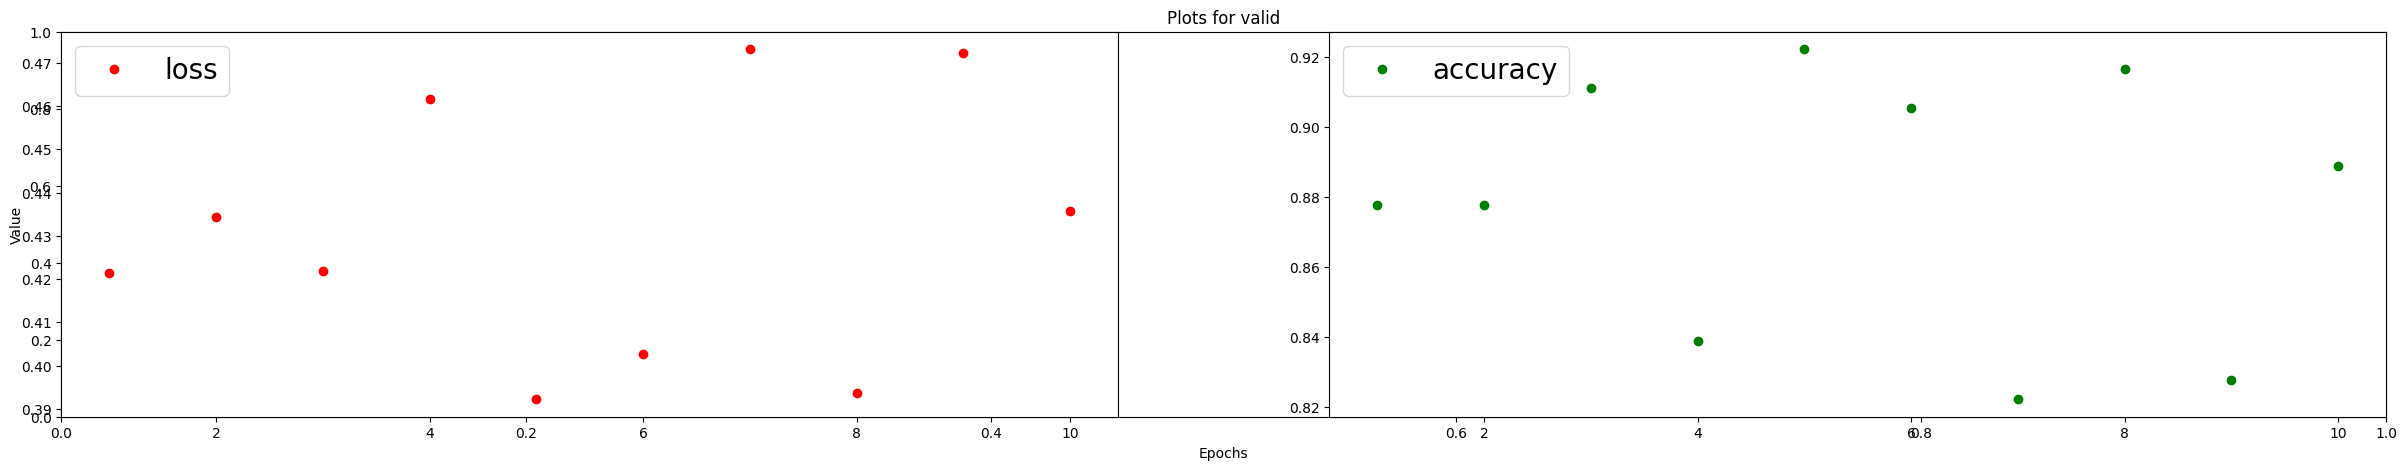

In [82]:
print('Learning rate: 0.0005, Batch size: 20')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

train_loader = torch.utils.data.DataLoader(
    dataset=train_data, batch_size=20, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    dataset=test_data, batch_size=20, shuffle=True)
val_loader = torch.utils.data.DataLoader(
    dataset=val_data, batch_size=20, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0007, Batch size: 20
Epoch : 1, train accuracy : 0.8902022838592529, train loss : 0.41750839352607727
Epoch : 1, val_accuracy : 0.8833333253860474, val_loss : 0.43359848856925964
Epoch : 2, train accuracy : 0.8925670981407166, train loss : 0.4178532660007477
Epoch : 2, val_accuracy : 0.9222221374511719, val_loss : 0.3995268642902374
Epoch : 3, train accuracy : 0.8874994516372681, train loss : 0.4198874235153198
Epoch : 3, val_accuracy : 0.9166666865348816, val_loss : 0.3972603380680084
Epoch : 4, train accuracy : 0.9020265340805054, train loss : 0.41057491302490234
Epoch : 4, val_accuracy : 0.8833332657814026, val_loss : 0.4256003201007843
Epoch : 5, train accuracy : 0.9013507962226868, train loss : 0.40606290102005005
Epoch : 5, val_accuracy : 0.911111056804657, val_loss : 0.4127402603626251
Epoch : 6, train accuracy : 0.8895265460014343, train loss : 0.4167729318141937
Epoch : 6, val_accuracy : 0.9277777671813965, val_loss : 0.3873491883277893
Epoch : 7, train accura

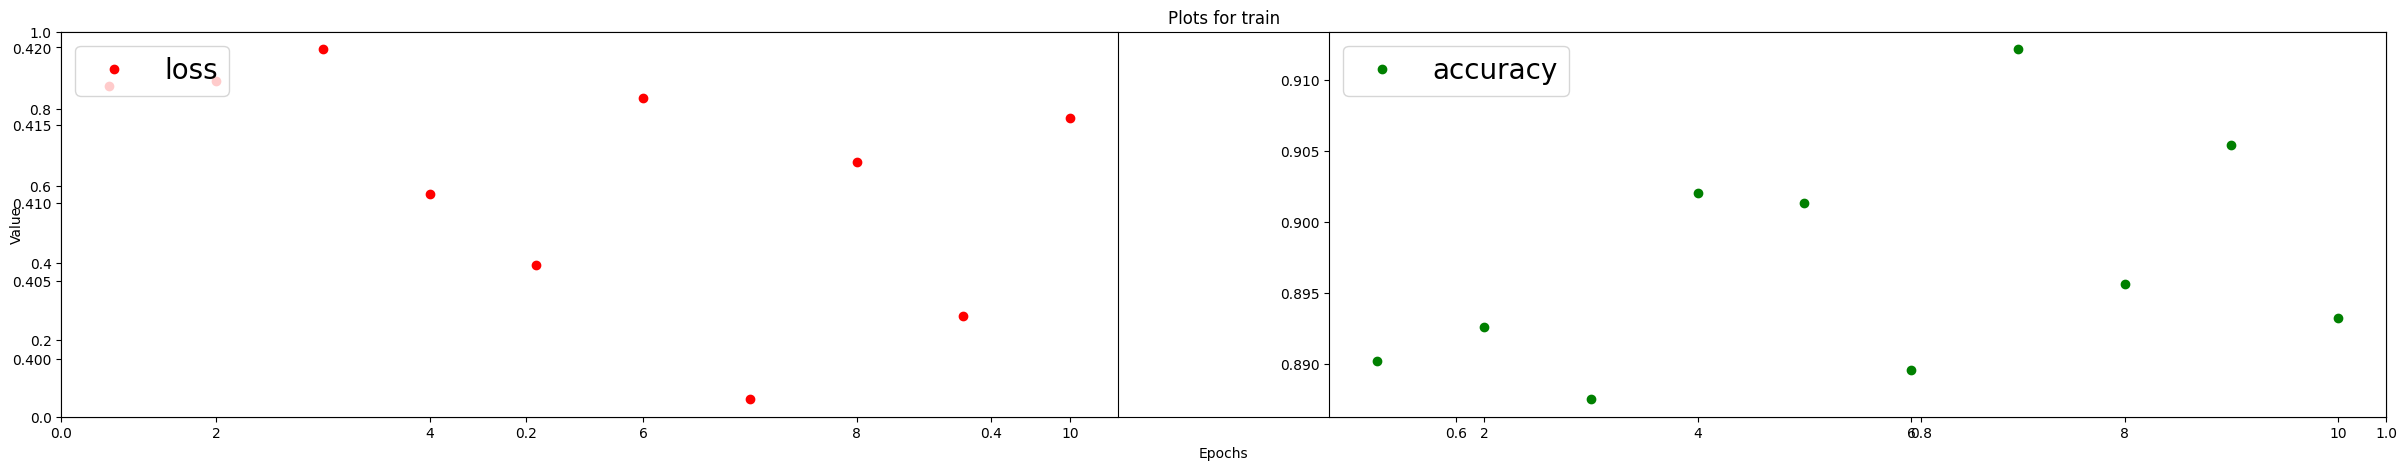

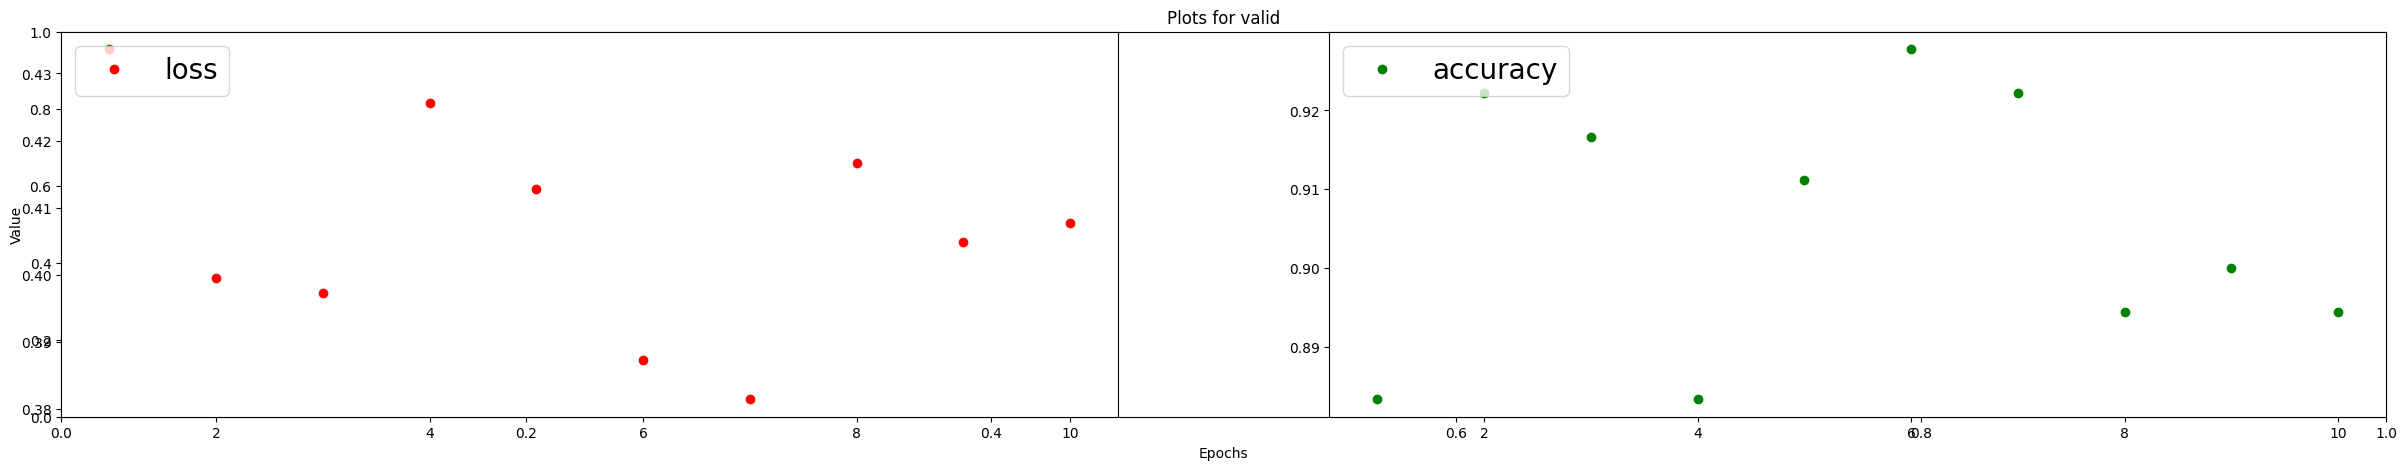

In [83]:
print('Learning rate: 0.0007, Batch size: 20')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

train_loader = torch.utils.data.DataLoader(
    dataset=train_data, batch_size=20, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    dataset=test_data, batch_size=20, shuffle=True)
val_loader = torch.utils.data.DataLoader(
    dataset=val_data, batch_size=20, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.001, Batch size: 50
Epoch : 1, train accuracy : 0.9131110310554504, train loss : 0.396710604429245
Epoch : 1, val_accuracy : 0.9149999618530273, val_loss : 0.3911755084991455
Epoch : 2, train accuracy : 0.9024443626403809, train loss : 0.40535011887550354
Epoch : 2, val_accuracy : 0.9549999833106995, val_loss : 0.37028810381889343
Epoch : 3, train accuracy : 0.9102962017059326, train loss : 0.3985322415828705
Epoch : 3, val_accuracy : 0.9300000071525574, val_loss : 0.392316609621048
Epoch : 4, train accuracy : 0.9128147959709167, train loss : 0.39963531494140625
Epoch : 4, val_accuracy : 0.8992856740951538, val_loss : 0.4066225290298462
Epoch : 5, train accuracy : 0.9069629907608032, train loss : 0.4015158712863922
Epoch : 5, val_accuracy : 0.9271429181098938, val_loss : 0.39185619354248047
Epoch : 6, train accuracy : 0.9144442677497864, train loss : 0.39706069231033325
Epoch : 6, val_accuracy : 0.934999942779541, val_loss : 0.3815141022205353
Epoch : 7, train accuracy

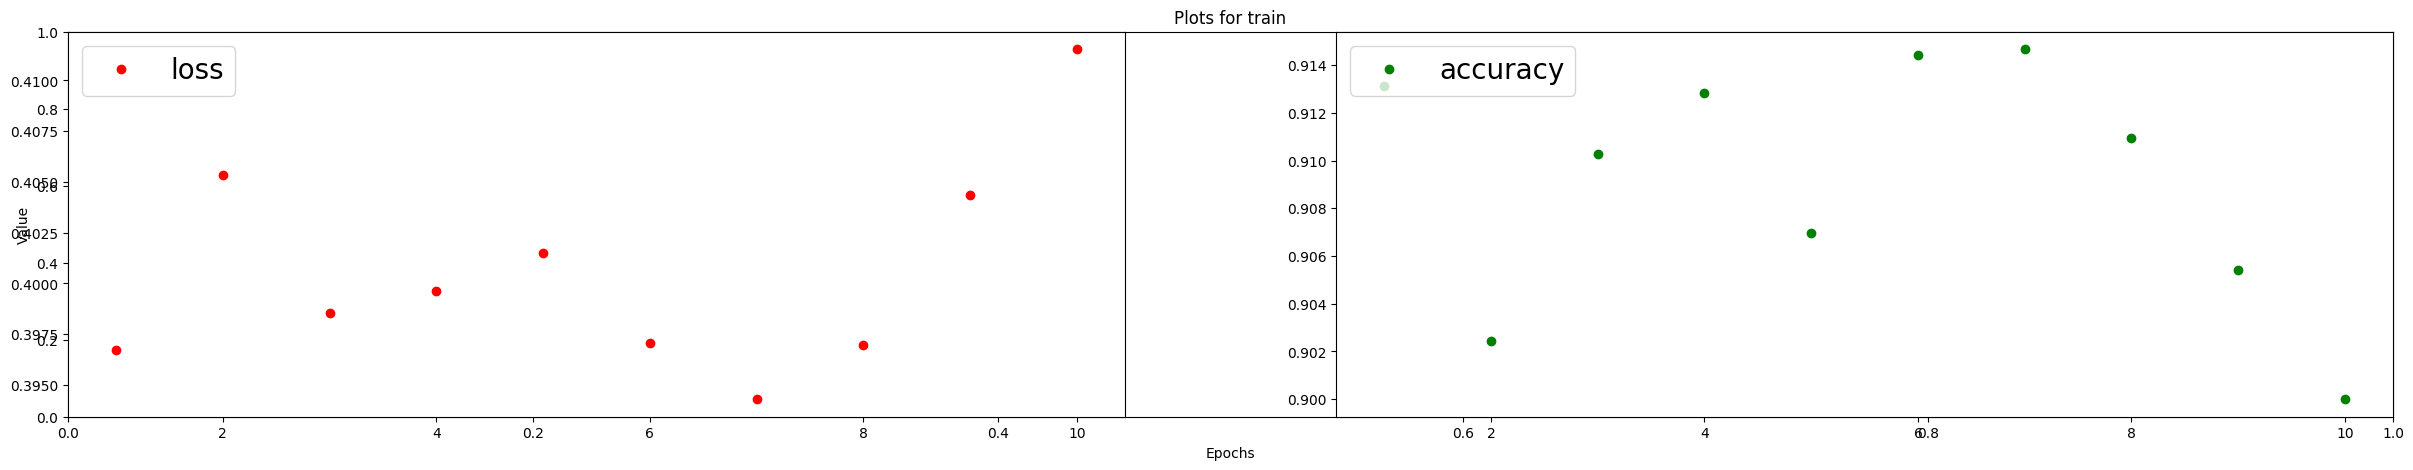

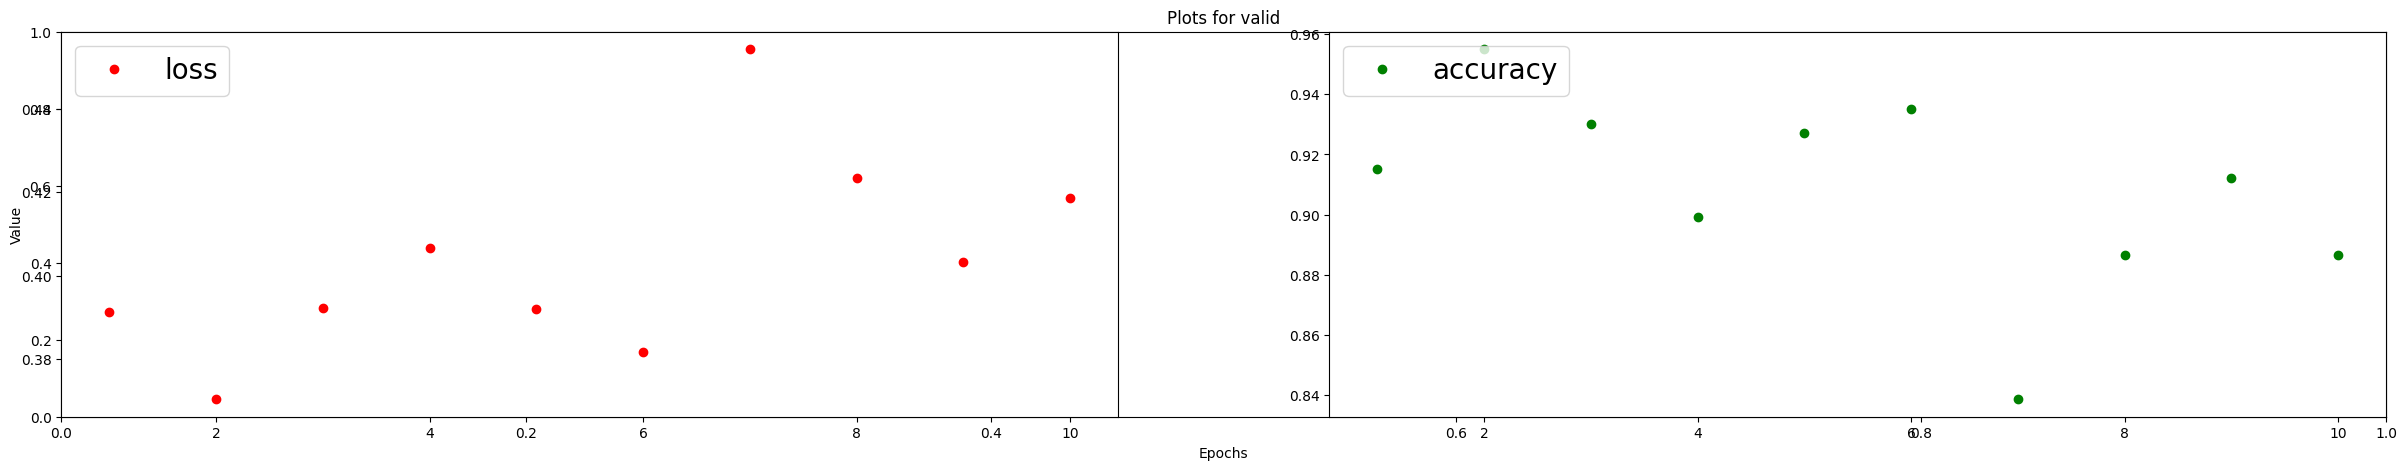

In [84]:
print('Learning rate: 0.001, Batch size: 50')

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loader = torch.utils.data.DataLoader(
    dataset=train_data, batch_size=50, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    dataset=test_data, batch_size=50, shuffle=True)
val_loader = torch.utils.data.DataLoader(
    dataset=val_data, batch_size=50, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0005, Batch size: 50
Epoch : 1, train accuracy : 0.898592472076416, train loss : 0.4092245101928711
Epoch : 1, val_accuracy : 0.9064285755157471, val_loss : 0.40811222791671753
Epoch : 2, train accuracy : 0.9164443016052246, train loss : 0.39093124866485596
Epoch : 2, val_accuracy : 0.927142858505249, val_loss : 0.3825201392173767
Epoch : 3, train accuracy : 0.911481499671936, train loss : 0.397251695394516
Epoch : 3, val_accuracy : 0.9071428775787354, val_loss : 0.4042889475822449
Epoch : 4, train accuracy : 0.9136295914649963, train loss : 0.39657172560691833
Epoch : 4, val_accuracy : 0.9249999523162842, val_loss : 0.3976854383945465
Epoch : 5, train accuracy : 0.9340000748634338, train loss : 0.3804894983768463
Epoch : 5, val_accuracy : 0.8814284801483154, val_loss : 0.42436107993125916
Epoch : 6, train accuracy : 0.9282962679862976, train loss : 0.3848345875740051
Epoch : 6, val_accuracy : 0.8764286041259766, val_loss : 0.41833096742630005
Epoch : 7, train accuracy

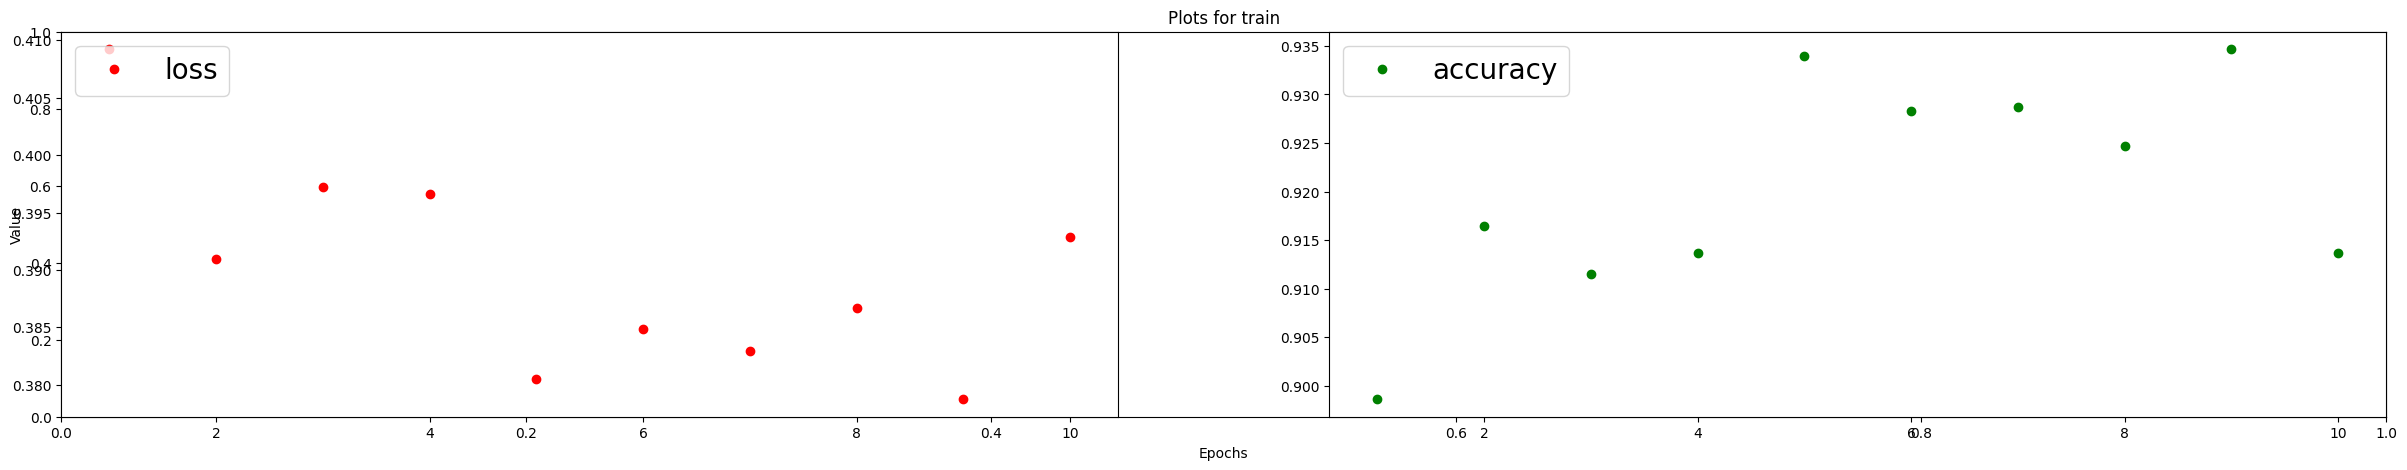

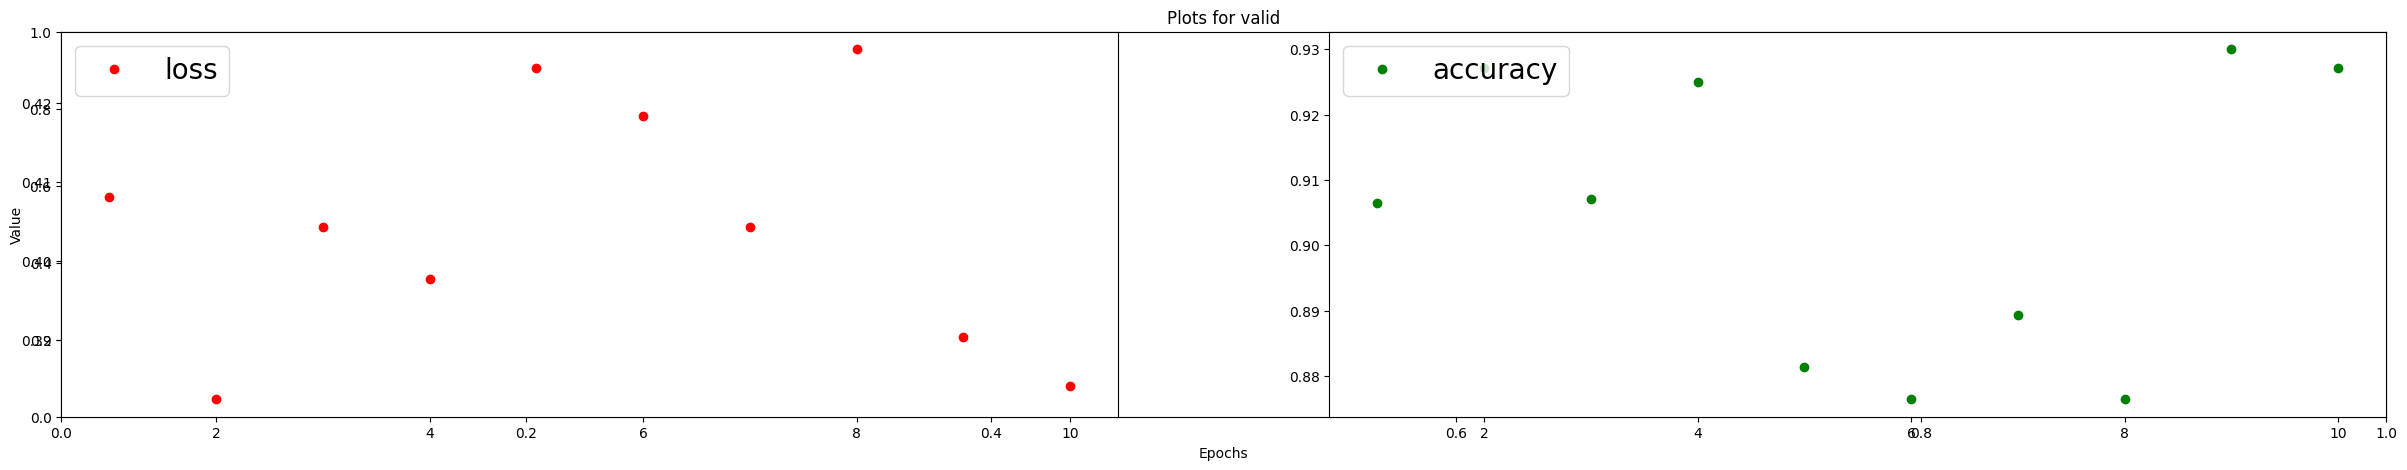

In [85]:
print('Learning rate: 0.0005, Batch size: 50')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

train_loader = torch.utils.data.DataLoader(
    dataset=train_data, batch_size=50, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    dataset=test_data, batch_size=50, shuffle=True)
val_loader = torch.utils.data.DataLoader(
    dataset=val_data, batch_size=50, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0007, Batch size: 50
Epoch : 1, train accuracy : 0.9154813885688782, train loss : 0.39590081572532654
Epoch : 1, val_accuracy : 0.9321428537368774, val_loss : 0.3799166977405548
Epoch : 2, train accuracy : 0.9188148379325867, train loss : 0.391488254070282
Epoch : 2, val_accuracy : 0.9249999523162842, val_loss : 0.39160674810409546
Epoch : 3, train accuracy : 0.9234815239906311, train loss : 0.3874097764492035
Epoch : 3, val_accuracy : 0.9321429133415222, val_loss : 0.38779106736183167
Epoch : 4, train accuracy : 0.917629599571228, train loss : 0.39084523916244507
Epoch : 4, val_accuracy : 0.9092857241630554, val_loss : 0.4030991196632385
Epoch : 5, train accuracy : 0.927333414554596, train loss : 0.38432052731513977
Epoch : 5, val_accuracy : 0.9342857003211975, val_loss : 0.38835859298706055
Epoch : 6, train accuracy : 0.9186666011810303, train loss : 0.3911778926849365
Epoch : 6, val_accuracy : 0.9092857241630554, val_loss : 0.40703949332237244
Epoch : 7, train accur

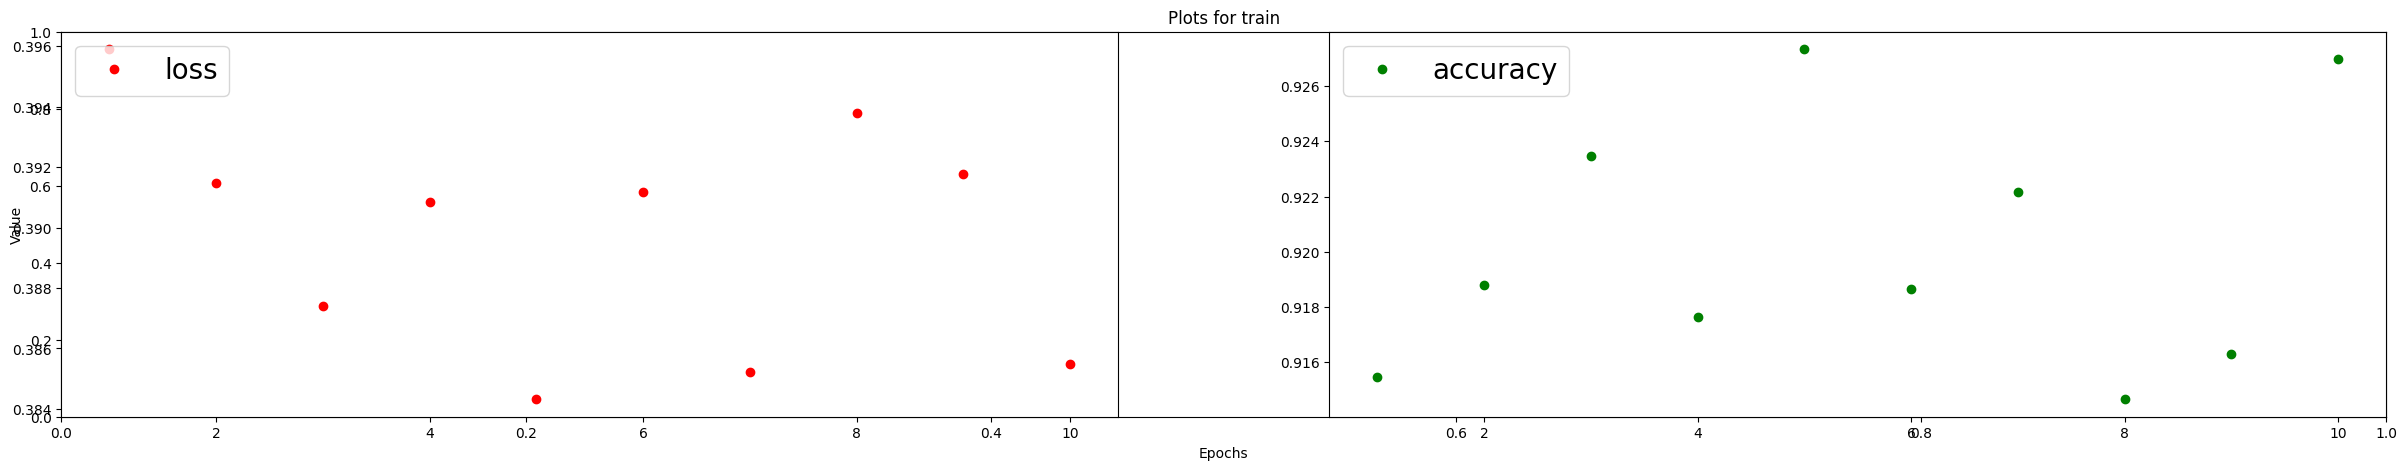

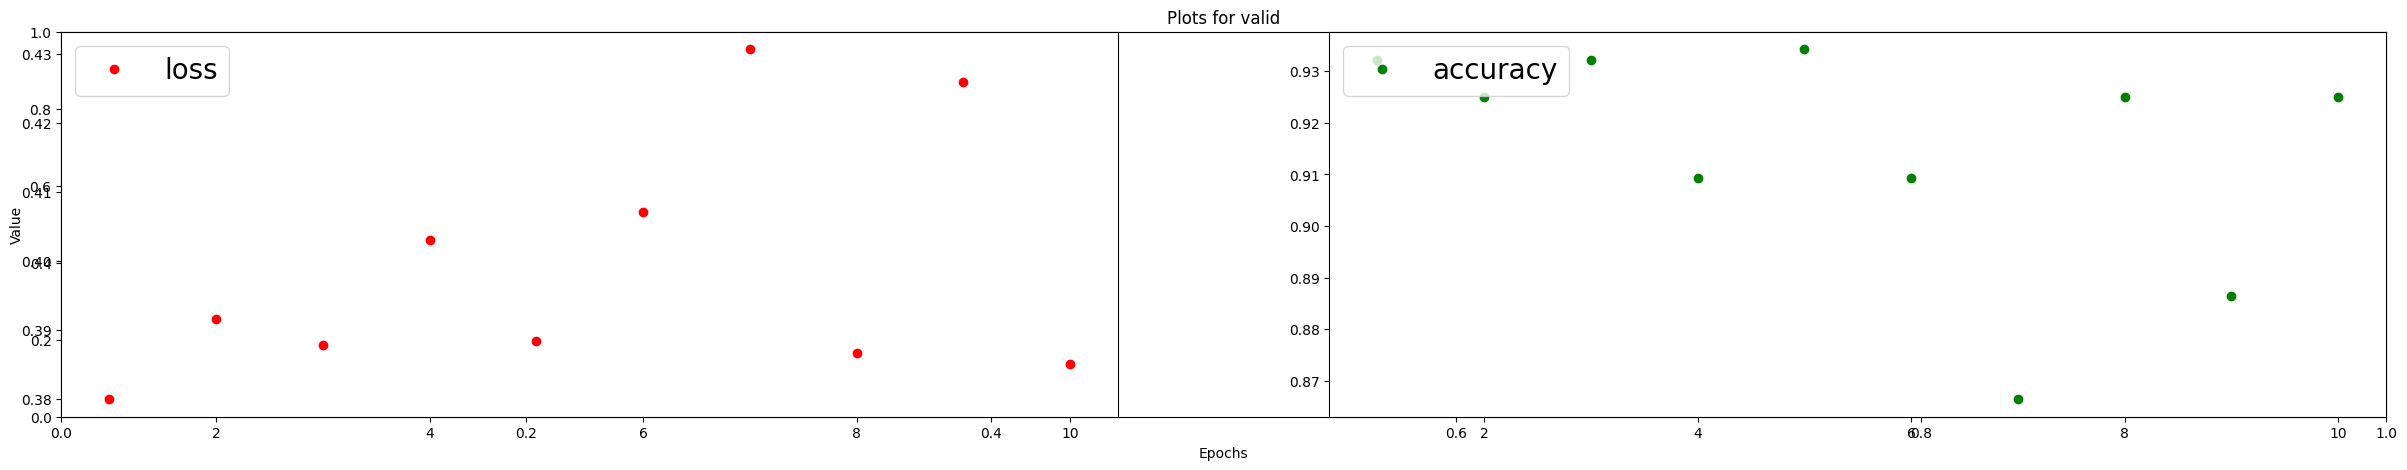

In [86]:
print('Learning rate: 0.0007, Batch size: 50')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

train_loader = torch.utils.data.DataLoader(
    dataset=train_data, batch_size=50, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    dataset=test_data, batch_size=50, shuffle=True)
val_loader = torch.utils.data.DataLoader(
    dataset=val_data, batch_size=50, shuffle=True)

train_loop(train_loader, val_loader, epochs)

In [87]:
rose_probs = []
model.eval()
with torch.no_grad():
    for data, fileid in test_loader:
        data = data.to(device)
        preds = model(data)
        preds_list = F.softmax(preds, dim=1)[:, 1].tolist()
        rose_probs += list(zip(list(fileid), preds_list))

idx = list(map(lambda x: x[0], rose_probs))
prob = list(map(lambda x: x[1], rose_probs))

submission = pd.DataFrame({'id': idx, 'label': prob})

submission

,id,label
0,76,0.728944
1,115,0.272677
2,54,0.731058
3,69,0.731030
4,161,0.720588
...,...,...
199,51,0.729960
200,78,0.731052
201,178,0.310335
202,6,0.721819


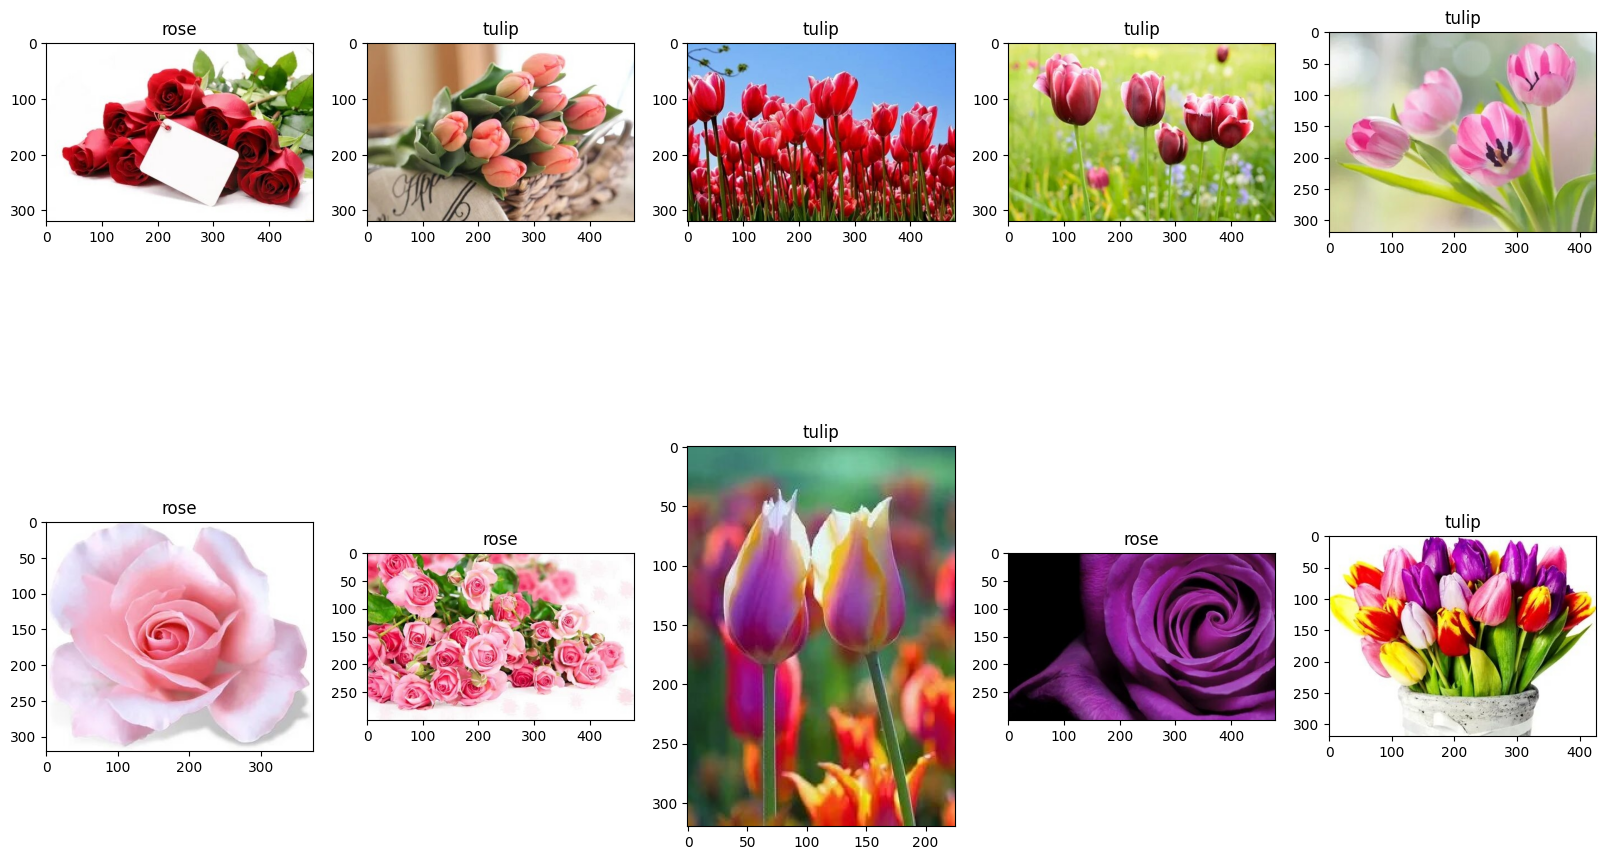

In [90]:
import random
class_ = {0: 'tulip', 1: 'rose'}

fig, axes = plt.subplots(2, 5, figsize=(20, 12), facecolor='w')

for ax in axes.ravel():

    i = random.choice(submission['id'].values)

    label = submission.loc[submission['id'] == i, 'label'].values[0]
    if label > 0.5:
        label = 1
    else:
        label = 0

    img_path = os.path.join(path_test, f'{i}.jpg')
    img = Image.open(img_path)

    ax.set_title(class_[label])
    ax.imshow(img)